# Antarctic temperature anomalies in tide run

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
from collections import OrderedDict
import cmocean.cm as cmocean
import cftime
import glob
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/Antarctic_tides_fixed/sfc_heat_flux/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44049 Dashboard: /proxy/41565/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


In [3]:
session = cc.database.create_session('/g/data/v45/akm157/jupyter_scripts/tides/ryf9091_tides.db')

In [4]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','update_bool':False}),
    ('01deg_RYF9091_tides',   {'expt':'01deg_jra55v13_ryf9091_tides_fixed','update_bool':True}),
                        ])
#start_time='2086-01-01'
start_time='2091-01-01'
end_time='2095-12-31'
time_period = str(int(start_time[:4])-2085)+'-'+str(int(end_time[:4])-2085)

lat_slice  = slice(-90,-59)

In [5]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

## Calculate shelf surface heat flux difference:

In [6]:
# control surface heat flux:

expt = '01deg_jra55v13_ryf9091'
net_sfc_heating_con = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(expt, 'sfc_hflux_coupler', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(expt, 'sfc_hflux_pme', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(expt, 'frazil_3d_int_z', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating_con = net_sfc_heating_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

# limit to shelf region:
net_sfc_heating_con  = shelf_mask_isobath(net_sfc_heating_con)[0]

# time avg control
# need to be careful to take account of split months in output:
n_days_con = cc.querying.getvar(expt,'time_bounds',session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_con = n_days_con.sel(time=slice(start_time,end_time))
n_days_con = (n_days_con.isel(nv=1) - n_days_con.isel(nv=0))/60/60/24/1e9
net_sfc_heating_con = (net_sfc_heating_con*n_days_con).sum('time')/n_days_con.sum('time')


In [7]:
# tides surface heat flux:

expt = '01deg_jra55v13_ryf9091_tides_fixed'
net_sfc_heating_tides = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(expt, 'sfc_hflux_coupler', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(expt, 'sfc_hflux_pme', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(expt, 'frazil_3d_int_z', session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating_tides = net_sfc_heating_tides.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

# limit to shelf region:
net_sfc_heating_tides  = shelf_mask_isobath(net_sfc_heating_tides)[0]

# time avg tides
# need to be careful to take account of split months in output:
n_days_tides = cc.querying.getvar(expt,'time_bounds',session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_tides = n_days_tides.sel(time=slice(start_time,end_time))
n_days_tides = (n_days_tides.isel(nv=1) - n_days_tides.isel(nv=0))/60/60/24/1e9
net_sfc_heating_tides = (net_sfc_heating_tides*n_days_tides).sum('time')/n_days_tides.sum('time')


In [8]:
# compute anomaly:
heat_flux_diff = net_sfc_heating_tides - net_sfc_heating_con

heat_flux_diff = heat_flux_diff.load()

In [9]:
# for plotting 1000m isobath:

contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

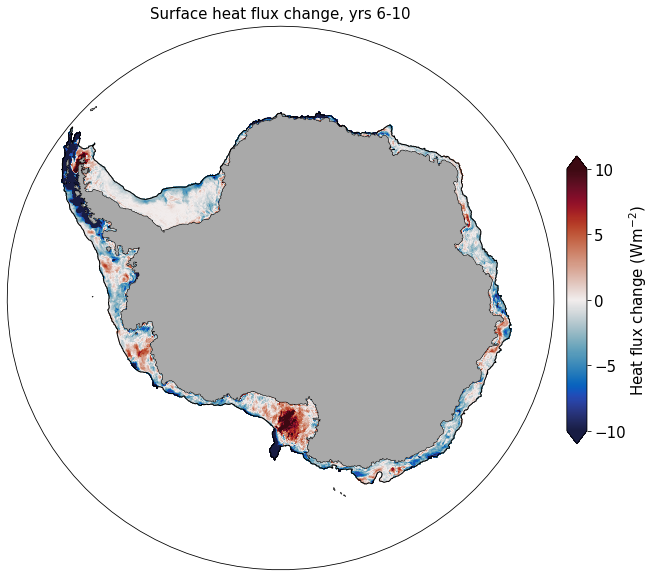

In [64]:
norm = col.Normalize(vmin=-10,vmax=10)
ticks=[-10,-5,0, 5, 10]

fontsize = 15

# unmasked arrays of lon and lat and land_mask:
ht = cc.querying.getvar('01deg_jra55v13_ryf9091','ht',session, n=1)
# needs to be same size as shelf mask:
ht = ht.sel(yt_ocean=slice(-90, -59.03))
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

# setup figure:
fig  = plt.figure(1, figsize = (10,10))
ax= plt.subplot(projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# add land:
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean, ht.yt_ocean,land_mask,[0,1], colors = 'k', linewidths = .5, 
           transform=ccrs.PlateCarree())

ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0.5], colors = 'k', linewidths = 1, 
           transform=ccrs.PlateCarree())

cf = ax.pcolormesh(heat_flux_diff.xt_ocean, heat_flux_diff.yt_ocean, heat_flux_diff, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())

plt.title('Surface heat flux change, yrs '+time_period,
          fontsize=fontsize,pad=8)

cbaxes = fig.add_axes([0.91, 0.3, 0.028, 0.4])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',ticks=ticks,extend = 'both')
cbar.set_label(r'Heat flux change (Wm$^{-2}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

figure_path = figdir+'net_sfc_heat_flux_anom_shelf_yrs'+time_period+'.png'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)

In [11]:
## shelf area average surface heat flux change:

area = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',session, n=1)
area = area.sel(yt_ocean=slice(-90, -59))

heat_flux_avg = (heat_flux_diff*area).sum('xt_ocean').sum('yt_ocean')
heat_flux_avg.values

# shelf avg heat flux change is -4.6 TW. So roughly all of extra heat brought onto shelf is lost to atmosphere. 
# I guess this could be different if we had ice to melt?

array(-4.59473173e+12)